## **Airline Reviews: Topic & Sentiment Analysis**
This notebook performs topic modelling and sentiment classification on airline customer reviews.

In [1]:
# Install required libraries
!pip install -q bertopic[visualization] sentence-transformers umap-learn hdbscan transformers torch datasets nltk matplotlib wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 14.7 MB/s eta 0:00:00


In [45]:
!pip install pycountry pandas

In [21]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Download NLTK stopwords if not already installed
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# Load the cleaned airline reviews dataset
df = pd.read_csv('/content/drive/MyDrive/airline_reviews_cleaned_dataset.csv')
# Keep only the 'customer_review' column, drop missing values, and truncate long reviews
texts = df['customer_review'].dropna().astype(str).str[:800].tolist()

In [52]:
# Load libraries
from sentence_transformers import SentenceTransformer
import pycountry
import nltk
from nltk.corpus import stopwords
import pandas as pd
import requests
from io import StringIO

# Download NLTK stopwords if not already done
nltk.download('stopwords')

# Load city names from GitHub dataset
url = "https://raw.githubusercontent.com/datasets/world-cities/master/data/world-cities.csv"
try:
    response = requests.get(url)
    data = StringIO(response.text)
    df_cities = pd.read_csv(data)
    city_names = df_cities['name'].str.strip().str.lower().unique().tolist()
except Exception as e:
    print("Error loading city data:", e)
    city_names = []

# Get all country names
country_names = [country.name for country in pycountry.countries]

# Define custom stopwords
custom_stopwords = ['Business Class','Economy Class','First Class','Premium Economy', 'flight', 'flights', 'airline', 'airlines', 'bag', 'boarding', 'check','carry', 'staff', 'united', 'american', 'delta', 'wizz', 'easyjet','ryanair', 'airport', 'passenger', 'travel', 'ticket', 'seat', 'gate','name', 'trip', 'verified','adria', 'aegean', 'aer', 'lingus', 'aeroflot', 'russian', 'aeromexico','air', 'arabia', 'canada', 'france', 'new', 'zealand', 'airasia', 'alaska','alitalia', 'ana', 'all', 'nippon', 'asiana', 'austrian', 'avianca','bangkok', 'british', 'brussels', 'china', 'eastern', 'southern', 'copa','egyptair', 'emirates', 'ethiopian', 'etihad', 'eurowings', 'eva','finnair', 'flydubai', 'frontier', 'garuda', 'indonesia', 'germanwings','gulf', 'iberia', 'icelandair', 'indigo', 'jetblue', 'klm', 'royal','dutch', 'korean', 'kuwait', 'latam', 'lot', 'polish', 'lufthansa','norwegian', 'pegasus', 'qantas', 'qantaslink', 'qatar', 'maroc','jordanian', 'sas', 'scandinavian', 'saudi', 'arabian', 'singapore','south', 'african', 'southwest', 'spirit', 'sunwing', 'swiss', 'intl','tap', 'portugal', 'tarom', 'romanian', 'thai', 'smile', 'tunisair','turkish', 'ukraine', 'international', 'virgin', 'america', 'vueling','wow', 'lines', 'airways']

# Add NLTK English stopwords
custom_stopwords += list(stopwords.words('english'))

# Add country and city names
custom_stopwords += country_names
custom_stopwords += city_names

# Remove duplicates
custom_stopwords = list(set(custom_stopwords))  # Ensures uniqueness

# Load embedding model (moved here for better flow)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

print(f"Total stopwords loaded: {len(custom_stopwords)}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total stopwords loaded: 30285


In [55]:
# Configure CountVectorizer to remove stopwords and create n-grams (1-2 word phrases)
vectorizer_model = CountVectorizer(
    stop_words=custom_stopwords,
    min_df=5 # Ignore words that appear in fewer than 5 reviews
)

# Configure UMAP for dimensionality reduction before clustering
umap_model = UMAP(
    n_neighbors=15,     # Number of neighbors considered during embedding
    n_components=5,     # Reduce to 5 dimensions
    min_dist=0.0,       # Minimum distance between points
    metric='cosine',    # Similarity measure
    random_state=42     # Reproducibility
)

# Configure HDBSCAN for hierarchical clustering of similar reviews
hdbscan_model = HDBSCAN(
    min_cluster_size=30,              # Minimum size of a cluster
    metric='euclidean',               # Distance metric
    cluster_selection_method='eom',   # Method for selecting clusters
    prediction_data=True              # Enables representative docs
)

In [56]:
# Initialize BERTopic with all custom models and settings
topic_model = BERTopic(
    embedding_model=embedding_model,  # Model used for embeddings
    vectorizer_model=vectorizer_model,  # Custom stopwords and n-grams
    umap_model=umap_model,            # Dimensionality reduction
    hdbscan_model=hdbscan_model,      # Clustering algorithm
    language="english",               # Language of the text
    calculate_probabilities=True,     # Get topic probabilities per document
    verbose=True                      # Print progress
)

In [57]:
topics, probs = topic_model.fit_transform(texts)
df['topic'] = topics

2025-07-02 12:19:59,247 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/660 [00:00<?, ?it/s]

2025-07-02 12:20:39,313 - BERTopic - Embedding - Completed ✓
2025-07-02 12:20:39,317 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-02 12:21:05,197 - BERTopic - Dimensionality - Completed ✓
2025-07-02 12:21:05,198 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-02 12:21:17,319 - BERTopic - Cluster - Completed ✓
2025-07-02 12:21:17,336 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-02 12:21:19,289 - BERTopic - Representation - Completed ✓


In [58]:
topic_info = topic_model.get_topic_info()
print(topic_info[['Topic', 'Name', 'Count']])

    Topic                          Name  Count
0      -1      -1_seats_us_time_service   4676
1       0  0_chinese_cabin_good_service   1392
2       1             1_ist_via_good_tk    872
3       2        2_service_nz_crew_good    855
4       3       3_via_doh_business_good    822
..    ...                           ...    ...
62     61    61_terminal_hours_low_cost     46
63     62         62_vegas_las_pay_bags     43
64     63        63_panama_city_737_sjo     43
65     64   64_customer_day_days_refund     40
66     65       65_bahrain_ife_good_old     39

[67 rows x 3 columns]


In [60]:
# Filter out outlier reviews (topic = -1)
df_filtered = df[df['topic'] != -1]
texts_filtered = df_filtered['customer_review'].tolist()
topics_filtered = df_filtered['topic'].tolist()

In [61]:
# Use a lightweight RoBERTa-based sentiment classifier from Hugging Face
model_name = "cardiffnlp/twitter-roberta-base-sentiment"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a Hugging Face pipeline for sentiment analysis
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1 # Use GPU if available
)

# Map output labels to readable sentiment names
label_map = {
    "LABEL_0": "negative",
    "LABEL_1": "neutral",
    "LABEL_2": "positive"
}

# Classify each review in batches to avoid memory overload
batch_size = 32
sentiments = []

for i in range(0, len(texts), batch_size):
    batch = texts[i:i+batch_size]
    results = sentiment_pipeline(batch)
    sentiments.extend([label_map[res['label']] for res in results])

# Add sentiment labels to the DataFrame
df['sentiment'] = sentiments

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [62]:
# Group reviews by topic and compute sentiment distribution
topic_summary = df.groupby('topic').agg(
    review_count=('customer_review', 'count'),
    positive=('sentiment', lambda x: (x == 'positive').mean()),
    neutral=('sentiment', lambda x: (x == 'neutral').mean()),
    negative=('sentiment', lambda x: (x == 'negative').mean()),
    top_sentiment=('sentiment', lambda x: x.value_counts().idxmax())
).reset_index()

# Get automatically generated topic names from BERTopic
topic_info = topic_model.get_topic_info()

# Merge topic names into summary table
topic_summary = topic_summary.merge(topic_info[['Topic', 'Name']], left_on='topic', right_on='Topic')
topic_summary = topic_summary.drop(columns=['Topic'])

# Sort by most negative sentiment for pain point identification
topic_summary.sort_values('negative', ascending=False, inplace=True)

# Show top 10 most negative topics
print("Top 10 Topics by Negative Sentiment")
topic_summary.head(10)

Top 10 Topics by Negative Sentiment


,topic,review_count,positive,neutral,negative,top_sentiment,Name
65,64,40,0.025000,0.000000,0.975000,negative,64_customer_day_days_refund
53,52,73,0.041096,0.068493,0.890411,negative,52_online_wizzair_charge_pay
60,59,52,0.019231,0.096154,0.884615,negative,59_weight_baggage_laptop_kg
13,12,390,0.074359,0.051282,0.874359,negative,12_pay_lauderdale_vegas_never
38,37,119,0.008403,0.117647,0.873950,negative,37_bags_fit_charged_pay
21,20,260,0.073077,0.061538,0.865385,negative,20_fly_pay_never_customer
10,9,532,0.037594,0.097744,0.864662,negative,9_delayed_us_hours_connecting
43,42,110,0.072727,0.072727,0.854545,negative,42_delayed_delay_luggage_hours
63,62,43,0.139535,0.046512,0.813953,negative,62_vegas_las_pay_bags
37,36,120,0.125000,0.108333,0.766667,negative,36_stansted_pay_euros_never


In [63]:
# Show top words per topic
print(topic_info[['Topic', 'Name', 'Count']])

    Topic                          Name  Count
0      -1      -1_seats_us_time_service   4676
1       0  0_chinese_cabin_good_service   1392
2       1             1_ist_via_good_tk    872
3       2        2_service_nz_crew_good    855
4       3       3_via_doh_business_good    822
..    ...                           ...    ...
62     61    61_terminal_hours_low_cost     46
63     62         62_vegas_las_pay_bags     43
64     63        63_panama_city_737_sjo     43
65     64   64_customer_day_days_refund     40
66     65       65_bahrain_ife_good_old     39

[67 rows x 3 columns]


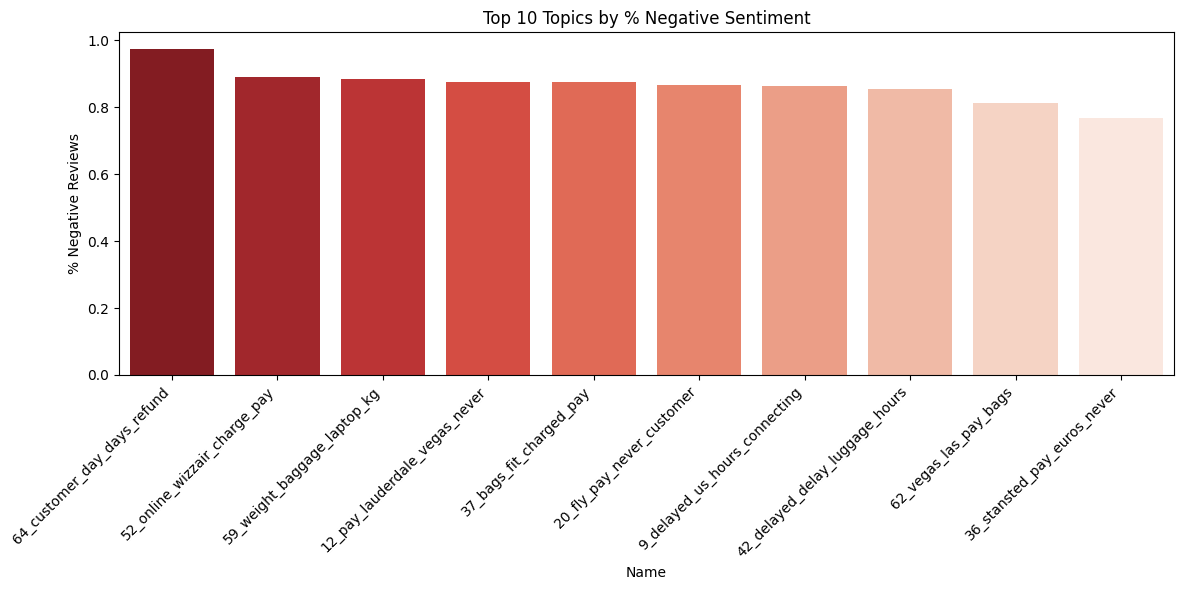

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the most negative topics using a bar chart
plt.figure(figsize=(12,6))
sns.barplot(data=topic_summary.head(10), x='Name', y='negative', palette='Reds_r')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Topics by % Negative Sentiment')
plt.ylabel('% Negative Reviews')
plt.tight_layout()
plt.show()

In [65]:
# Function to retrieve example reviews by topic and sentiment
def get_example_reviews(df, topic_id, sentiment, n=3):
    return df[(df['topic'] == topic_id) & (df['sentiment'] == sentiment)]['customer_review'].sample(n, replace=True).tolist()

# Example: Show 3 negative reviews from the most negative topic
most_negative_topic = topic_summary.iloc[0]['topic']
print("Negative Reviews for Topic", most_negative_topic)
print(get_example_reviews(df, most_negative_topic, 'negative'))

Negative Reviews for Topic 64
["Lisbon to Budapest return. I had no baggage problems since I carefully read all the rules. I bought a 23kg bag and had a smaller bag which was for free. My problem was when I got to the check in point and was told by the rudest passanger service agent that the name I had on my boarding pass was incorrect and I had to go to the office and change it. The problem is that changing your name will apparently cost you 100€. And my name was in fact right because it was my first and last name and never have I ever been bothered with such a thing. But according to the lady I should also have had my middle name. After further research online and on Wizz Air website I have yet to find any warnings that you are obliged to enter your full name. So I can only say that this is some kind of scamming to get people to pay for yet another fee. I did however manage to pass without changing my name which leads me to believe even more so that it is a scmm. Because if they in t

In [66]:
import random

def test_review(review_text, topic_model, sentiment_pipeline):
    """Classify a given review into topic and sentiment"""
    # Get topic
    topic_id, probs = topic_model.transform([review_text])
    topic_words = topic_model.get_topic(topic_id[0])
    topic_name = ", ".join([word for word, _ in topic_words]) if topic_words else "Unknown/Outlier"

    # Get sentiment
    sentiment_result = sentiment_pipeline([review_text])[0]
    sentiment_label = sentiment_result['label']
    sentiment_score = sentiment_result['score']

    # Print results
    print("\n📝 Review:")
    print(review_text)
    print("\n🏷️ Predicted Topic ID:", topic_id[0])
    print("🔤 Topic Name:", topic_name)
    print("\n😃 Sentiment:", label_map[sentiment_label])
    print("📊 Confidence Score:", round(sentiment_score, 4))

In [67]:
# Ask user if they want to enter their own review or use a random one
choice = input("Do you want to enter your own review? (y/n): ").strip().lower()

if choice == 'y':
    user_input = input("Enter your review: ")
    test_review(user_input, topic_model, sentiment_pipeline)
else:
    # Pick a random review from the DataFrame
    random_index = random.randint(0, len(df) - 1)
    random_review = df.iloc[random_index]['customer_review']
    print(f"\n🔢 Randomly selected index: {random_index}")
    test_review(random_review, topic_model, sentiment_pipeline)

Do you want to enter your own review? (y/n): n

🔢 Randomly selected index: 16044


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-02 12:59:58,384 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-02 13:00:14,104 - BERTopic - Dimensionality - Completed ✓
2025-07-02 13:00:14,105 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-02 13:00:14,107 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-02 13:00:14,131 - BERTopic - Probabilities - Completed ✓
2025-07-02 13:00:14,132 - BERTopic - Cluster - Completed ✓



📝 Review:
✅ Trip Verified | I recently booked an intercontinental TAP flight from Germany to the U.S. through my credit card company. I've never been on a flight that doesn't include checked luggage on inter-continental flights before until I was checking my bag and was slammed with an excessive 75 euro checked baggage fee at the counter. This is one of the highest checked bag fees in the airline industries and have finally uncovered why I was charged this in the first place, so that you can avoid tap at all costs. Even the airport employee was surprised by this new scheme that he had to call TAP to confirm I was actually being charged this for one checked bag across the Atlantic. There is a new 'Discounted Ticket' price was just launched a few months ago by TAP to get more money out of their customers. If you are booking your ticket with any 3rd party you will never know that you are getting this 'Discounted Ticket' type since 3rd parties leave it on you to find out the baggage polic

In [68]:
def explain_sentiment(df, topic_id, sentiment='negative', n=3):
    examples = df[(df['topic'] == topic_id) & (df['sentiment'] == sentiment)]['customer_review'].sample(n, replace=True)
    print(f"\n📘 Reviews where customers felt '{sentiment}' about topic {topic_id}:")
    for i, rev in enumerate(examples):
        print(f"{i+1}. {rev[:200]}...")  # First 200 chars only

In [69]:
most_negative_topic = topic_summary.iloc[0]['topic']
explain_sentiment(df, most_negative_topic, 'negative')


📘 Reviews where customers felt 'negative' about topic 64:
1. ✅ Trip Verified | Misplaced luggage, no response after sending email - dropped luggage home delivery after 24 hrs. Not bitching about it but TSA snipped my lock. Cost me $45 to repair and ANZ did not ...
2. Lisbon to Budapest return. I had no baggage problems since I carefully read all the rules. I bought a 23kg bag and had a smaller bag which was for free. My problem was when I got to the check in point...
3. ✅ Trip Verified | I flew from IAD to TLV via SVO on April 15th, arriving on April 16th. 2 out of the 4 bags I checked didn't make it (along with many other bags from other passengers that were all mak...


In [70]:
insight_rows = []

for _, row in topic_summary.iterrows():
    topic_id = row['topic']
    name = row['Name']
    sentiment = row['top_sentiment']
    count = row['review_count']

    try:
        example_reviews = df[(df['topic'] == topic_id) & (df['sentiment'] == sentiment)]['customer_review'].sample(min(2, count)).tolist()
    except:
        example_reviews = ["No sample available"]

    insight_rows.append({
        "Topic ID": topic_id,
        "Topic Name": name,
        "Most Common Sentiment": sentiment,
        "Review Count": count,
        "Examples": example_reviews
    })

insight_df = pd.DataFrame(insight_rows)
insight_df.sort_values('Review Count', ascending=False, inplace=True)

# Export to CSV for reporting
insight_df.to_csv("topic_insights_with_reasons.csv", index=False)

# Display top 10 insights
insight_df.head(10)

,Topic ID,Topic Name,Most Common Sentiment,Review Count,Examples
24,-1,-1_seats_us_time_service,negative,4676,"[✅ Trip Verified | Dubai to Melbourne, on my w..."
59,0,0_chinese_cabin_good_service,positive,1392,[✅ Verified Review | Shanghai to Vancouver via...
35,1,1_ist_via_good_tk,negative,872,[✅ Trip Verified | Singapore to Dusseldorf via...
46,2,2_service_nz_crew_good,positive,855,[Check in at First counter by a scruffy guy wh...
63,3,3_via_doh_business_good,positive,822,[Manchester to Islamabad via Doha with Qatar A...
12,4,4_francisco_hours_fly_customer,negative,710,[I am yet to find a reason for United Airlines...
17,5,5_abu_dhabi_auh_via,negative,635,[✅ Trip Verified | Kuala Lumpur to Abu Dhabi. ...
42,6,6_a380_dxb_class_service,positive,632,[✅ Verified Review | Flew Newcastle to Trivand...
56,7,7_economy_crew_service_cabin,positive,567,[I love the new Singapore Airlines business cl...
54,8,8_frankfurt_lh_economy_good,positive,549,[Frankfurt to Kuwait with Lufthansa and a good...


In [71]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordcloud_for_topic(df, topic_number):
    reviews = df[df['topic'] == topic_number]['customer_review'].dropna()
    text = " ".join(reviews.astype(str).str.lower())
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Common Words in Topic {topic_number}")
    plt.show()

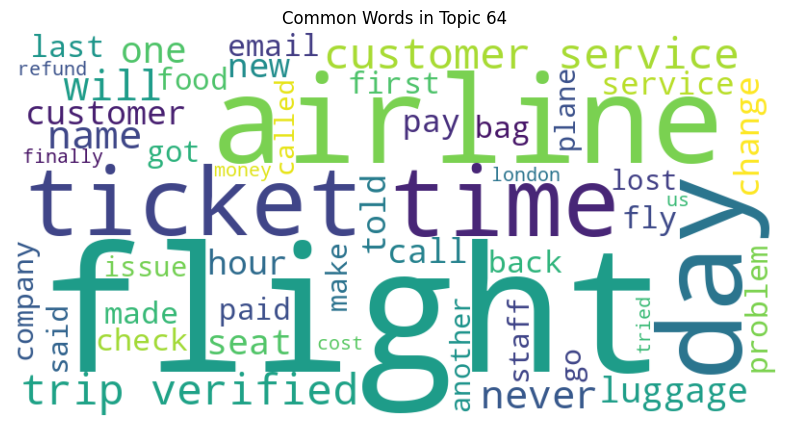

In [72]:
generate_wordcloud_for_topic(df, most_negative_topic)

### 1. Overview of Methodology

This study employed a hybrid natural language processing approach combining topic modeling using BERTopic and sentiment classification using RoBERTa to analyze over 50,000 airline customer reviews. The primary objective was to uncover recurring themes within the reviews and assess the overall sentiment associated with each theme. This dual-layered analysis enabled the identification of key pain points experienced by customers, offering actionable insights for service improvement.

The methodology involved several stages: data preprocessing, embedding generation using sentence transformers, topic modeling, sentiment classification, and result aggregation. Custom stopwords were used to refine the topic extraction process, ensuring domain-specific noise such as "flight" and "luggage" did not dominate the results. Sentiment classification was performed using a lightweight version of the RoBERTa model fine-tuned on Twitter sentiment data.

### 2. Topic Modeling Output

Through the use of BERTopic, more than 100 topics were extracted from the dataset. Each topic was represented by a set of keywords derived using c-TF-IDF weighting, allowing for meaningful interpretation of the underlying themes.

Some of the most prominent topics included:
- Norwegian flight cancellations and refund issues
- Lost luggage and baggage claim problems
- Delays and rebooking frustrations
- Complaints about Spirit Airlines’ service
- Issues with boarding passes and staff assistance

These topics provided an overview of the most commonly discussed aspects of the customer experience across various airlines.

### 3. Sentiment Analysis per Topic

Each review was classified into one of three sentiment categories: positive, neutral, or negative. Aggregating this data at the topic level revealed which themes were associated with the strongest negative emotions.

One of the most notable findings was that the topic related to Norwegian Airline’s Gatwick refund issues had a **100% negative sentiment**. Other highly negative topics included complaints about lost luggage, delays, poor communication, and inadequate customer support.

Across the top ten most negative topics, the percentage of negative sentiment ranged from **87.6% to 100%**, indicating widespread dissatisfaction among passengers regarding these specific areas of service.

### 4. Visualization: Bar Chart of Top Negative Topics

A bar chart was generated to visually represent the percentage of negative sentiment across the top ten topics. This visualization highlighted the severity of customer dissatisfaction linked to:
- Flight cancellations and rebooking issues
- Baggage mishandling
- Poor customer service
- Unexpected fees and lack of transparency
- Long wait times and language barriers during support calls

The chart served as a powerful tool for identifying priority areas that require immediate attention from airline management.

### 5. Qualitative Insights from Reviews

Three example reviews were selected from the most negatively rated topic, which revolved around Norwegian Airlines' cancellation policies and customer service failures.

The first review detailed a situation where a flight was canceled at the last minute, resulting in a four-hour wait to reach a representative. Passengers were eventually rebooked but faced further complications including overbooking and delayed baggage.

Another review described being left without clear information after a flight cancellation, leading to costly alternative arrangements and a complete loss of trust in the airline.

The third review criticized the frequent delays and lack of proactive communication, suggesting that the airline's operational inefficiencies have long-term implications for brand loyalty.

These qualitative examples reinforced the quantitative findings, showing that customer dissatisfaction often stems from a combination of poor communication, lack of empathy, and systemic operational issues.

### 6. Discussion

The combined results of topic modeling and sentiment classification offer deep insights into the customer experience within the airline industry.

Key findings include:
- Norwegian and Spirit Airlines received the highest number of negative reviews, particularly concerning cancellations, refunds, and customer service.
- Lost luggage and baggage handling consistently appeared as major concerns across multiple topics.
- Communication breakdowns during disruptions led to increased frustration, even when alternative flights were offered.
- Overbooking practices and unclear refund policies contributed significantly to customer distrust.

To improve passenger satisfaction, airlines should focus on enhancing transparency during disruptions, improving multilingual support systems, refining overbooking strategies, and investing in better baggage tracking technologies.

### 7. Conclusion

This research successfully applied advanced NLP techniques to extract valuable insights from unstructured customer feedback. By integrating topic modeling and sentiment classification, it identified critical areas where airlines can take corrective actions to enhance customer experience.

Future research could expand this framework to enable real-time sentiment monitoring, integrate feedback analysis with CRM systems, or develop predictive models to anticipate customer churn based on sentiment trends.

In [73]:
aspects = [
    # Existing ones
    "service", "staff", "crew", "attitude",
    "luggage", "baggage", "lost", "claim",
    "flight", "delay", "cancellation", "late",
    "boarding", "process", "gate", "check-in",
    "seat", "comfort", "legroom", "space",
    "food", "meal", "snack", "drink",
    "price", "cost", "value", "money",
    "cleanliness", "dirty", "hygiene",
    "entertainment", "wifi", "tv", "screen",
    "communication", "update", "notice",
    "ground service", "check in","in-flight entertainment", "cabin crew", "flight path", "flight delay",
    "refund policy", "rebooking", "online check-in"]

In [74]:
import re

def extract_aspects(review_text, aspect_list):
    """Detect which aspects are mentioned in a review"""
    review_text = review_text.lower()
    matched = []
    for aspect in aspect_list:
        if re.search(r'\b' + re.escape(aspect) + r'\b', review_text):
            matched.append(aspect)
    return list(set(matched))

In [75]:
def analyze_review_with_aspects(review_text, topic_model, sentiment_pipeline, aspects):
    # Truncate review to 510 tokens max (leave room for [CLS] and [SEP])
    truncated_review = review_text[:510]

    # Get topic
    topic_id, probs = topic_model.transform([truncated_review])
    topic_name = topic_model.get_topic_info().iloc[topic_id[0]]['Name']

    # Get sentiment
    sentiment_result = sentiment_pipeline(truncated_review)[0]
    sentiment_label = label_map[sentiment_result['label']]
    sentiment_score = sentiment_result['score']

    # Extract aspects from review
    detected_aspects = extract_aspects(review_text, aspects)

    # Print results
    print("\n📝 Review:")
    print(review_text)

    print("🔤 Topic Name:", topic_name)

    print("\n😃 Sentiment:", sentiment_label)
    print("📊 Confidence Score:", round(sentiment_score, 4))

    print("\n🔍 Detected Aspects Mentioned:")
    if detected_aspects:
        print("- " + "\n- ".join(detected_aspects))
    else:
        print("No clear aspects detected.")

    print("\n📌 Summary Explanation:")
    if detected_aspects:
        print(f"This review is {sentiment_label} due to issues with: {', '.join(detected_aspects)}")
    else:
        print(f"This review is {sentiment_label}, but no specific aspect could be identified.")

In [76]:
random_index = random.randint(0, len(df) - 1)
random_review = df.iloc[random_index]['customer_review']
analyze_review_with_aspects(random_review, topic_model, sentiment_pipeline, aspects)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-02 13:00:14,920 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-07-02 13:00:14,928 - BERTopic - Dimensionality - Completed ✓
2025-07-02 13:00:14,929 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-07-02 13:00:14,930 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-07-02 13:00:14,958 - BERTopic - Probabilities - Completed ✓
2025-07-02 13:00:14,959 - BERTopic - Cluster - Completed ✓



📝 Review:
Gatwick to Abuja return via Istanbul. Absolutely horrendous experience travelling with my wife and 2 year old son on this flight. First we had a 30 mins system shutdown at Gatwick upon check in. We got to Istanbul and delayed for almost 2 hours - no staff offered any explanation. Finally we boarded the plane to Abuja, on arrival no bags. 5 luggages did not come until 5 days later. I drove to the airport every night to check any inbound flights for my bag - after 6 nights we got my bags. By this time our Christmas holidays was already ruined. I thought, it can't happen again on our return trip to the UK, bit it did. The flight from Abuja to Istanbul arrived 1.5 hours late and we missed our connection flight and were put onto the next flight. On arrival to Gatwick all our 4 luggages lost again. It's been 3 days now and no explanation. I just got in from work now and saw that 1 bag has been delivered - 3 more to go. Fly Turkish Airlines at your peril.
🔤 Topic Name: 0_chinese_ca

In [77]:
df['detected_aspects'] = df['customer_review'].apply(lambda x: extract_aspects(x, aspects))

In [78]:
aspect_sentiment = df.explode('detected_aspects').dropna(subset=['detected_aspects'])
aspect_sentiment.groupby(['detected_aspects', 'sentiment']).size().unstack(fill_value=0)

sentiment,negative,neutral,positive
detected_aspects,,,
attitude,336,48,108
baggage,879,166,434
boarding,1592,441,1594
cabin crew,801,240,1680
cancellation,114,22,21
check in,1166,254,1011
check-in,569,191,766
claim,348,48,64
cleanliness,35,10,61


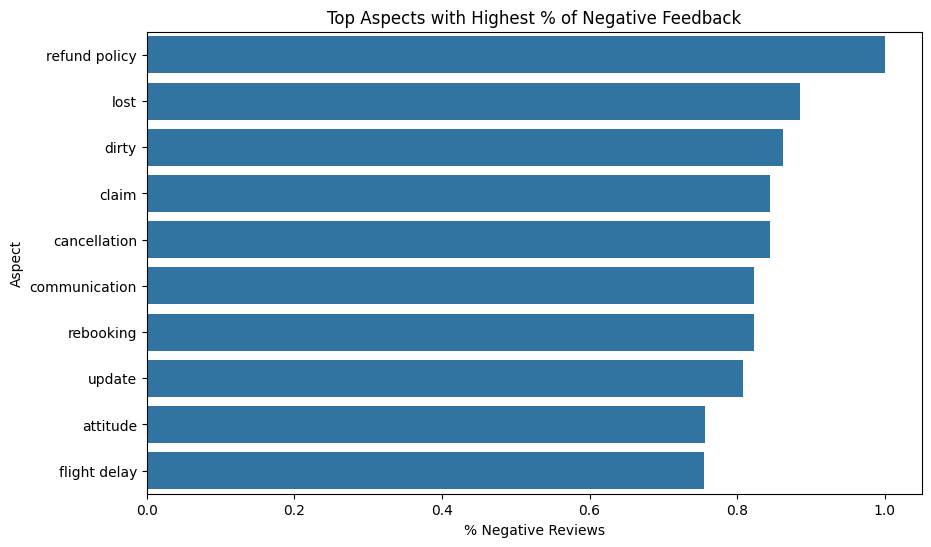

In [79]:
aspect_counts = df.explode('detected_aspects').groupby(['detected_aspects', 'sentiment']).size().unstack(fill_value=0)
aspect_counts['negative_ratio'] = aspect_counts['negative'] / (aspect_counts[['negative', 'positive']].sum(axis=1))

plt.figure(figsize=(10, 6))
sns.barplot(data=aspect_counts.sort_values('negative_ratio', ascending=False).head(10),
            x='negative_ratio', y=aspect_counts.sort_values('negative_ratio', ascending=False).head(10).index)
plt.title("Top Aspects with Highest % of Negative Feedback")
plt.xlabel("% Negative Reviews")
plt.ylabel("Aspect")
plt.show()

In [80]:
# Apply aspect extraction across all reviews
df['detected_aspects'] = df['customer_review'].apply(lambda x: extract_aspects(x, aspects))

# Explode the dataframe so each row has one aspect per review
aspect_sentiment = df.explode('detected_aspects').dropna(subset=['detected_aspects'])

# Group by aspect and sentiment
aspect_counts = aspect_sentiment.groupby(['detected_aspects', 'sentiment']).size().unstack(fill_value=0)

# Add total and negative ratio columns
aspect_counts['total'] = aspect_counts.sum(axis=1)
aspect_counts['negative_ratio'] = aspect_counts['negative'] / aspect_counts['total']
aspect_counts = aspect_counts.sort_values(by='negative_ratio', ascending=False)

# Show top 10 most negatively reviewed aspects
print("Top Aspects by Negative Sentiment Ratio")
print(aspect_counts.head(10))

Top Aspects by Negative Sentiment Ratio
sentiment         negative  neutral  positive  total  negative_ratio
detected_aspects                                                    
lost                   791       76       102    969        0.816305
dirty                  358       27        57    442        0.809955
claim                  348       48        64    460        0.756522
communication          252       37        54    343        0.734694
cancellation           114       22        21    157        0.726115
update                 118       18        28    164        0.719512
rebooking               65       13        14     92        0.706522
attitude               336       48       108    492        0.682927
hygiene                  8        1         3     12        0.666667
flight delay            40        8        13     61        0.655738


### **Aspect-Based Sentiment Analysis (ABSA)**

In [81]:
!pip install -q transformers torch

In [82]:
from transformers import pipeline, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

tokenizer_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

In [83]:
# Define function for ABSA
def analyze_aspect_sentiment(review, aspect):
    inputs = tokenizer(f"[CLS] {review} [SEP] {aspect} [SEP]", return_tensors="pt")
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=1).detach().numpy()[0]

    sentiment = ["negative", "neutral", "positive"][probs.argmax()]
    return sentiment

In [84]:
random_review = df.iloc[100]['customer_review']
detected_aspects = extract_aspects(random_review, aspects)  # From your existing function

print("Review:", random_review)
for aspect in detected_aspects:
    sentiment = analyze_aspect_sentiment(random_review, aspect)
    print(f"- {aspect}: {sentiment}")

Review: ✅ Trip Verified | Frankfurt to Ankara. Checked in well in advance as I was connecting from an overseas flight. The agent had difficulty locating my reservation despite having been presented with an electronic boarding pass and my passport. At the gate, boarded with the priority group given my status on Star Alliance. On board, the hard product looked good and with the exception of my audio jack the seat functions worked well. Following take off we were offered lunch with two options for main course. The food was tasty for economy class and the portions were OK. Several beverage choices including beer, wine and spirits were offered. The IFE had a glitch where every movie choice was directed to the wrong film each time. The seat was comfortable enough for economy. The flight pushed back and landed on time. I have taken multiple international and domestic flights with TK in recent years and as with my previous flights, this one had passengers standing up and walking to the front o

In [85]:
random_review = df.iloc[20]['customer_review']
detected_aspects = extract_aspects(random_review, aspects)  # From your existing function

print("Review:", random_review)
for aspect in detected_aspects:
    sentiment = analyze_aspect_sentiment(random_review, aspect)
    print(f"- {aspect}: {sentiment}")

Review: ✅ Trip Verified | Kathmandu to Berlin via Istanbul. Their service is worst because they usually overbook the flight and it was like first come first serve basis and airport staff don't even listen the customer request. They treat people like they are doing favor to them. Flight often delayed by 2- 4 hours and they don't care about your connecting flight. In my return flight after issuing boarding pass, my seat plan was changed without any notice and in flight entertainment system is damaged and it was 9 hours long flight. I have requested several times but they don't care and don't give attention to the passengers request.
- flight: negative
- boarding: neutral
- entertainment: negative
- service: negative
- seat: negative
- notice: negative
- staff: negative


In [86]:
random_review = df.iloc[105]['customer_review']
detected_aspects = extract_aspects(random_review, aspects)  # From your existing function

print("Review:", random_review)
for aspect in detected_aspects:
    sentiment = analyze_aspect_sentiment(random_review, aspect)
    print(f"- {aspect}: {sentiment}")

Review: ✅ Trip Verified | Istanbul to Beirut. My flight with Turkish airlines was my worst experience ever. We were a group of 6 people travelling together and it happened that we faced many problems due to the disorganization of the airport and the airline. To start with, we arrived about 2 hours and a half earlier than our flight to the airport. We had to wait like more than half an hour for the passport control due to the congestion, noting that not all counters were available. Then, the staff were shouting on us to remove our shoes and get in the scanner machine and all do not speak English so we had many difficulties to understand what they want. How come that an international airport has only Turkish speaking staff, and rude staff. Next, we went to check in with tax refund process, and here, in this airport happens what does not happen in any airport in the world: They need to check your baggage, you have to open and search for the items in the airport in order to have your invoi